<a href="https://colab.research.google.com/github/liz0904/ai_titanic/blob/main/titanic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/gdrive/')

Mounted at /gdrive/


In [80]:
#<데이터 로딩>

#라이브러리 설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#데이콘 사이트에서 다운로드한 csv 파일 읽어오기
drive_path="/gdrive/MyDrive/"
train=pd.read_csv(drive_path+"titanic/train.csv") #판다스 read_csv 함수를 사용해 csv 파일을 읽고 데이터 프레임으로 변환
test=pd.read_csv(drive_path+"titanic/test.csv")
submission=pd.read_csv(drive_path+"titanic/sample_submission.csv")  #제출 파일 양식
print(train.shape, test.shape, submission.shape)  #몇행 몇열인지 확인

(891, 12) (418, 11) (418, 2)


In [81]:
#train 데이터 프레임 내용 확인-생존여부(생존 1, 사망 0)
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [82]:
#test 데이터프레임 내용 확인- 목표변수에 대한 데이터 없음(테스트 데이터라서)
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [ ]:
#submission 제출 파일 양식 확인
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
#train 데이터프레임 개요 정보-891보다 작은 개수의 non-null 데이터가 있는데, 부족한 개수만큼 missing value 존재
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [83]:
#train 데이터프레임 통계 정보
train.describe(include='all') #all-숫자형이 아닌 문자열 등에 대한 정보를 포함해 show

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Staneff, Mr. Ivan",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


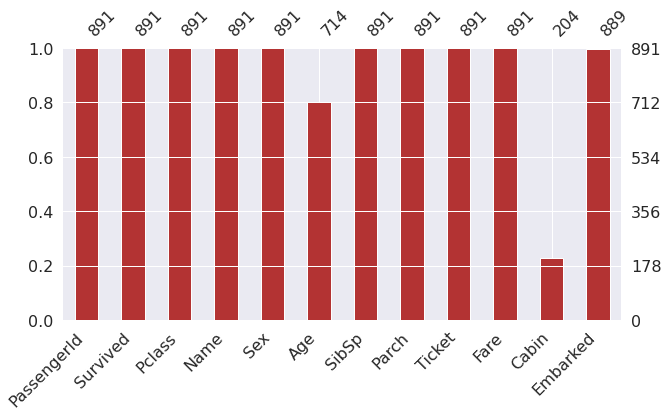

In [84]:
#결측값 분포-missingno 라이브러리 사용
import missingno as msno
msno.bar(train, figsize=(10,5), color=(0.7, 0.2, 0.2))
plt.show()  #Age, Cabin, Embarked 열에 결측값 존재

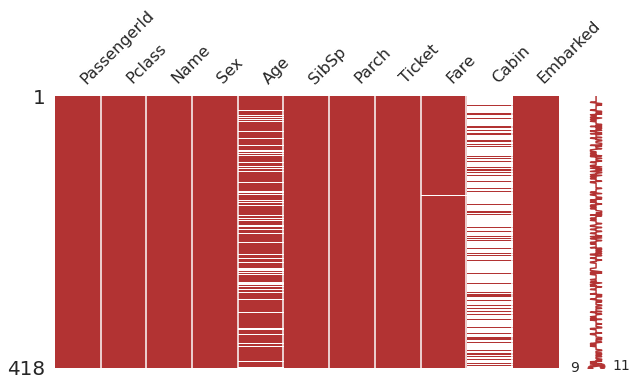

In [85]:
#matrix 함수: 데이터프레미의 어느위치에 결측값이 있는지 확인
msno.matrix(test, figsize=(10,5), color=(0.7, 0.2, 0.2))
plt.show()

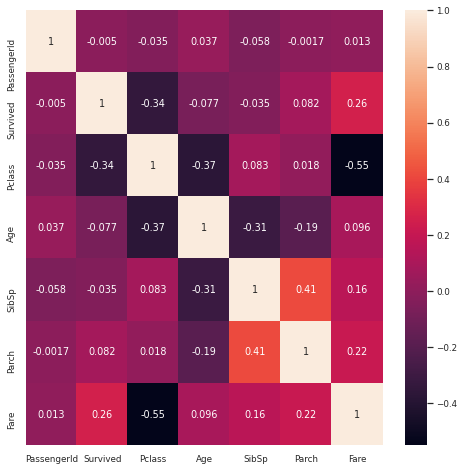

In [86]:
#상관 관계 분석
#숫자형 변수 간의 상관관계를 계산하여 히트맵 그리기
plt.figure(figsize=(8,8))
sns.set(font_scale=0.8)
sns.heatmap(train.corr(), annot=True, cbar=True); #corr 함수: 숫자형 데이터로 구성된 열에 대해서만 상관계수를 계산
plt.show()  #Survived(목표변수)열과 상관관계가 높은 피처는 Pclass와 Fare, 또 Pclass와 Rase끼리의 상관계수(-0.55)도 높음

In [88]:
#데이터 결합-타이타닉 전체 데이터셋 준비
train['TrainSplit']='Train'
test['TrainSplit']='Test'
data=pd.concat([train, test], axis=0) #concat 함수로 데이터프레임(train, test)을 위아래 방향(axis=0)으로 연결
print(data.shape)

(1309, 13)


In [89]:
#데이터 전처리
#숫자형 피처 추출
data_num=data.loc[:,['Pclass','Age','SibSp','Parch', 'Fare', 'Survived']]

#결측값 대체-fillna 함수 사용
data_num['Age']=data_num['Age'].fillna(data_num['Age'].mean())    #Age열의 결측값은 평균값(mean)으로 대체
data_num['Fare']=data_num['Fare'].fillna(data_num['Fare'].mean()) #Fare열의 결측값은 가장 많은 빈도수(최빈값)으로 대체

#학습용 데이터와 예측 대상인 테스트 데이터 구분
selected_features=['Pclass', 'Age','SibSp', 'Parch', 'Fare']
x_train=data_num.loc[data['TrainSplit']=='Train', selected_features]
y_train=data_num.loc[data['TrainSplit']=='Train', 'Survived']

x_test=data_num.loc[data['TrainSplit']=='Test', selected_features]

print("Train 데이터셋 크기:", x_train.shape, y_train.shape)
print("Test 데이터셋 크기", x_test.shape)

Train 데이터셋 크기: (891, 5) (891,)
Test 데이터셋 크기 (418, 5)


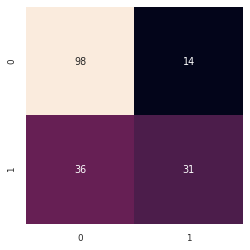

In [90]:
#모델 학습 및 검증-로지스틱 회귀 분류 모델
#훈련 - 검증 데이터 분할(y_val_pred:검증 데이터에 대한 예측값, y_val: 실제값)
#학습데이터 x_train, y_train을 훈련데이터 80%, 검증데이터 20%으로 분할
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val=train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=20)

#로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression()
lr_model.fit(x_tr, y_tr)
y_val_pred=lr_model.predict(x_val)

#Confusion Matrix-혼동 행력 계산 및 그래프로 표시
# *혼동 행렬: 모형의 예측값과 실제값을 각각 축으로 하는 2X2 매트릭스로 표현한 것(정밀도, 재현율, F1 지표 산출 가능)
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, cbar=False, square=True)
plt.show()


In [91]:
#평가 지표
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

print("Accuracy:%.3f" %accuracy_score(y_val,y_val_pred))
print("Precision: %.4f" %precision_score(y_val, y_val_pred))  #정밀도: True로 예측한 분석 대상 중에서 실제값이 True인 비율 (높을수록  False Positive 오류가 작음)
print("Recall: %4.f" %recall_score(y_val,y_val_pred))         #재현율: 실제 True 중에서 True로 예측하여 모형이 적중한 비율 (높을 수록 False Negative 오류가 낮음)
print("F1: %.4f" %f1_score(y_val,y_val_pred))                 #F1 지표: 정확도와 재현율의 조화 평균 (높을 수록 분류 모형의 예측력이 좋음)
print("AUC: %.4f" %roc_auc_score(y_val, y_val_pred))          #데이콘 경진대회에서 사용하는 평가지표 (1에 가까울 수록 예측력이 좋은 모델)

Accuracy:0.721
Precision: 0.6889
Recall:    0
F1: 0.5536
AUC: 0.6688


In [92]:
#모델 예측
#test 데이터에 대한 예측값 정리
y_test_pred=lr_model.predict(x_test)

#제출 양식에 맞게 정리
submission['Survived']=y_test_pred.astype(int)  #astype 함수로 예측값을 정수형으로 변환

#제출 파일 저장
submission_filepath=drive_path+'baseline_num_lr_submission_001.csv'
submission.to_csv(submission_filepath, index=False)
submission.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [93]:
#피처 엔지니어링(+EDA)

#Survived: 생존 여부
#타깃 레이블의 분포 확인
train['Survived'].value_counts(dropna=False)  #생존자 342명

0    549
1    342
Name: Survived, dtype: int64

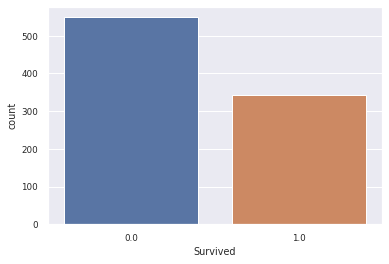

In [94]:
#객실 등급별 분포 확인
sns.countplot(x='Survived', data=data[data['TrainSplit']=='Train'])
plt.show()

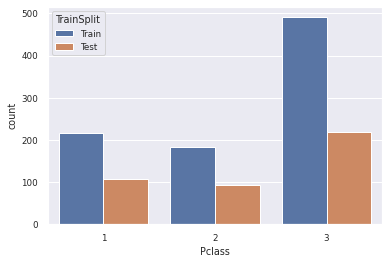

In [95]:
#train-test 데이터 분포
#3등석 승객이 가장 많고, 1~2등석은 비슷함
sns.countplot(x='Pclass', hue='TrainSplit', data=data)
plt.show()

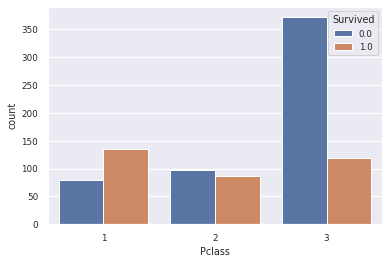

In [96]:
#객실 등급(Pclass)에 따른 생존자(Survived) 비율 확인
sns.countplot(x='Pclass', hue='Survived', data=data[data['TrainSplit']=='Train'])
plt.show()

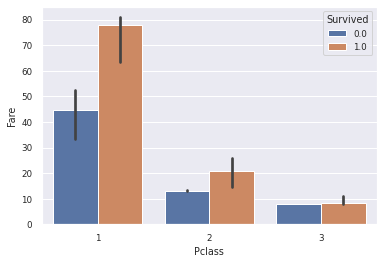

In [97]:
#등급별 객실(Pclass)별 객실 요금(Fare)의 중간값(median)의 분포
sns.barplot(x='Pclass',y='Fare', hue='Survived', data=data[data['TrainSplit']=='Train'], estimator=np.median)
plt.show()  #생존자들이 지불한 객실요금이 높은 패턴을 보임

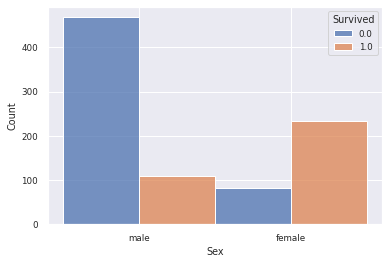

In [98]:
#남녀 성별에 따른 생존율 분포 파악
sns.histplot(x='Sex', hue='Survived', multiple='dodge', data=data[data['TrainSplit']=='Train']) #multiple 속성에 dodge를 설정하면 hue 옵션의 데이터를 기준으로 막대 그래프를 서로 겹치지 않게 수평으로 펼쳐서 분리 표시
plt.show()

In [99]:
#레이블 인코딩(female=0, male=1)
#문자열 데이터를 그대로 학습에 사용할 수 없기에, 숫자형 데이터로 변환하는 작업
data.loc[data['Sex']=='female', 'Sex']=0
data.loc[data['Sex']=='male', 'Sex']=1
data['Sex']=data['Sex'].astype(int)

#성별 분포 확인
data['Sex'].value_counts(dropna=False)

1    843
0    466
Name: Sex, dtype: int64

In [100]:
#Name:이름 - 문자열 데이터를 다루는 방법 스터디
data['Name'].unique() #unique 함수로 고유값을 확인

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina', ..., 'Saether, Mr. Simon Sivertsen',
       'Ware, Mr. Frederick', 'Peter, Master. Michael J'], dtype=object)

In [101]:
#Name 열을 선택하고 str 속성을 적용하면 문자열을 직접 추출할 수 있음
#split 메소드를 적용하면 문자열을 쉼표 기준을 분할함 -> 타이틀(Mr, Ms 등)이 들어있는 뒷부분의 문자열을 따로 추출
title_name=data['Name'].str.split(", ", expand=True)[1]
title_name

0                                 Mr. Owen Harris
1      Mrs. John Bradley (Florence Briggs Thayer)
2                                     Miss. Laina
3              Mrs. Jacques Heath (Lily May Peel)
4                               Mr. William Henry
                          ...                    
413                                     Mr. Woolf
414                                 Dona. Fermina
415                           Mr. Simon Sivertsen
416                                 Mr. Frederick
417                             Master. Michael J
Name: 1, Length: 1309, dtype: object

In [102]:
#타이틀부분([0])과 성([1])을 나눔
title=title_name.str.split(".", expand=True)[0]
title.value_counts(dropna=False)

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Don               1
Sir               1
Jonkheer          1
Lady              1
the Countess      1
Capt              1
Dona              1
Mme               1
Name: 0, dtype: int64

In [103]:
#비슷한 속성을 가진 타이틀끼리 같은 그룹으로 묶기
#replace 함수를 타이틀이 들어있는 시리즈 객체에 적용하면 리스트 안의 문자열들을 뒤에 나오는 문자열로 모두 바꿈
title=title.replace(['Ms'], 'Miss')
title=title.replace(['Mlle', 'ths Countess', 'Lady', 'Don','Dona','Mme', 'Sir', 'Jonkheer'],'Noble')
title=title.replace(['Col', 'Major', 'Capt'], 'Officer')
title=title.replace(['Dr', 'Rev'], 'Priest')
data['Title']=np.array(title)
data['Title'].value_counts(dropna=False)

Mr              757
Miss            262
Mrs             197
Master           61
Priest           16
Noble             8
Officer           7
the Countess      1
Name: Title, dtype: int64

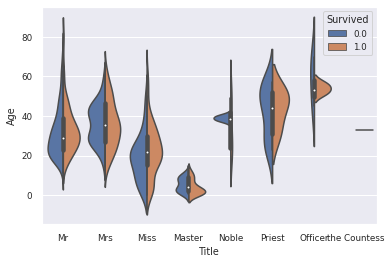

In [104]:
#승객 나이와 생존 여부와의 관계
sns.violinplot(x='Title', y='Age', hue='Survived', data=data, split=True)
plt.show()

In [105]:
#불필요해진 Name열은 데이터 프레임에서 삭제(의미있는 건 앞에서 Title 열에 저장함)
#왜 오류가 날까 ㅠㅠ
data = data.drop('Name', axis=1)
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'TrainSplit', 'Title'],
      dtype='object')

In [106]:
#나이 Age열의 결측값 확인
for title in data['Title'].unique():
  #결측값 개수 확인
  print("%s 결측값 개수:" %title, data.loc[data['Title']==title, 'Age'].isnull().sum())
  #각 Title의 중간값으로 대체
  age_med=data.loc[data['Title']==title, 'Age'].median()
  data.loc[data['Title']==title,'Age']=data.loc[data['Title']==title, 'Age'].fillna(age_med)

#결측값 처리 여부 확인
print("\n")
print("Age 열의 결측값 개수", data['Age'].isnull().sum())

Mr 결측값 개수: 176
Mrs 결측값 개수: 27
Miss 결측값 개수: 51
Master 결측값 개수: 8
Noble 결측값 개수: 0
Priest 결측값 개수: 1
Officer 결측값 개수: 0
the Countess 결측값 개수: 0


Age 열의 결측값 개수 0


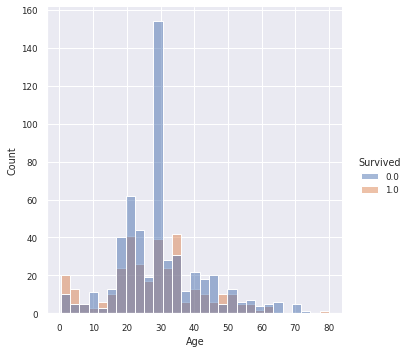

In [107]:
#Age 분포
sns.displot(x='Age', kind='hist', hue='Survived', data=data[data['TrainSplit']=='Train'])
plt.show()

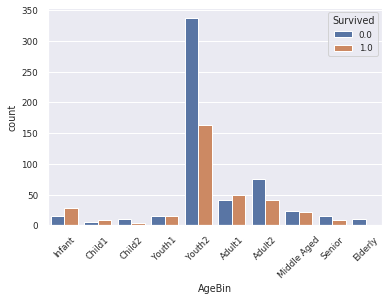

In [108]:
#나이에 따라 생존율에 차이가 나기 때문에 앞의 히스토그램 분포를 기준으로 Age 열의 데이터를 여러 개의 구간으로 나눔
#Binning-구간 나누기
bins=[0,4,8,12,16,32,36,48,56,64,100]
labels=['Infant','Child1','Child2','Youth1','Youth2', 'Adult1', 'Adult2','Middle Aged','Senior','Elderly']
data['AgeBin']=pd.cut(data['Age'],bins=bins,labels=labels)  #각 구간의 이름(lable) 지정, 각 구간의 나누는 경계값(bin), cut 함수를 사용해 분할

#Age_bin(나이 구간)에 따른 생존율 비교
sns.countplot(x='AgeBin', hue='Survived', data=data[data['TrainSplit']=='Train'])
plt.xticks(rotation=45)
plt.show()

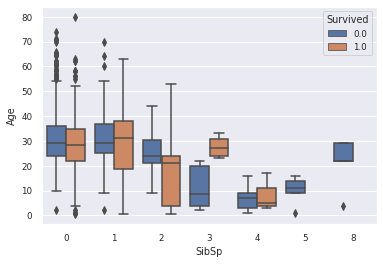

In [109]:
#형제자매/배우자 수와 승객 나이 및 생존율 관계
sns.boxplot(x='SibSp', y='Age', hue='Survived', data=data[data['TrainSplit']=='Train'])
plt.show()  #동승자가 2~3명일 경우, 나이에 따른 생존 여부에 차이가 있음

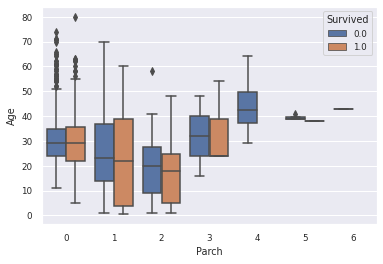

In [110]:
#부모/자식 수에 따른 승객 나이 및 생존율 관계
sns.boxplot(x='Parch', y='Age', hue='Survived', data=data[data['TrainSplit']=='Train'])
plt.show()  #동승자가 4명 이상일 경우 생존자가 거의 없음

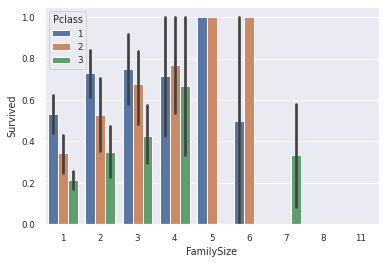

In [111]:
#가족 구성원의 수
data['FamilySize']=data['SibSp']+data['Parch']+1

#가족 구성원의 수와 생존율 관계
sns.barplot(x='FamilySize', y='Survived', hue='Pclass', estimator=np.mean, data=data[data['TrainSplit']=='Train'])
plt.show()  #가족 수에 따라 객실 등급에 따른 생존율에 차이가 있음

In [112]:
#Fare(요금)

#결측값 확인-1개의 결측 데이터 존재
data.loc[data['Fare'].isnull(), :]  

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TrainSplit,Title,AgeBin,FamilySize
152,1044,NaN,3,1,60.5,0,0,3701,NaN,NaN,S,Test,Mr,Senior,1


In [113]:
#3등석 요금의 평균값을 가지고 결측값 대체
p3_fare_mean=data.loc[data['Pclass']==3, 'Fare'].mean()
print(p3_fare_mean)
data['Fare']=data['Fare'].fillna(p3_fare_mean)
data.loc[data['PassengerId']==1044,:'Fare']

13.302888700564969


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare
152,1044,NaN,3,1,60.5,0,0,3701,13.302889


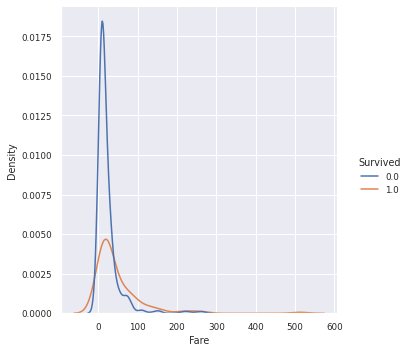

In [114]:
#Fare 분포
sns.displot(x='Fare', kind='kde', hue='Survived', data=data[data['TrainSplit']=='Train']) #displot의 kind옵션을 'kde'로 설정하고 밀도함수 그래프를 그림
plt.show()  #왼쪽으로 치우친 비대칭 분포

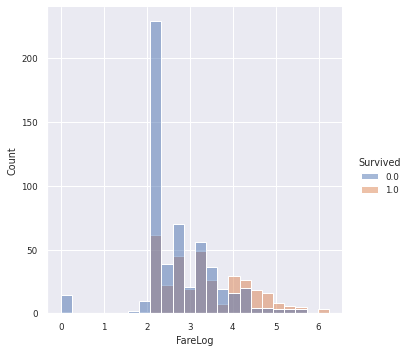

In [115]:
#비대칭 분포를 정규화 하기 위한 로그 변환
data['FareLog']=np.log1p(data['Fare'])  #log1p 함수를 이용해 Fare열의 데이터에 로그를 취하면, 정규분포와 가까운 형태로 변환

#FareLog 분포
sns.displot(x='FareLog', kind='hist', hue='Survived', data=data[data['TrainSplit']=='Train'])
plt.show()  #요금이 낮은 쪽으로 데이터가 비어있는 구간이 있음

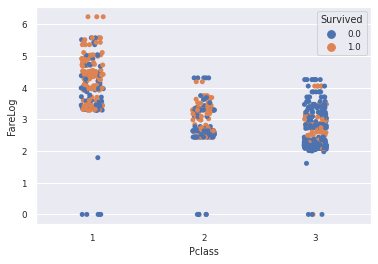

In [116]:
#객실 등급 별 객실 요금 분포와 생존율
sns.stripplot(x='Pclass', y='FareLog', hue='Survived', data=data[data['TrainSplit']=='Train'])
plt.show()

In [117]:
#Embarked(탑승 항구)
#결측값 확인-결측값 2개
data.loc[data['Embarked'].isnull(), :]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TrainSplit,Title,AgeBin,FamilySize,FareLog
61,62,1.0,1,0,38.0,0,0,113572,80.0,B28,NaN,Train,Miss,Adult2,1,4.394449
829,830,1.0,1,0,62.0,0,0,113572,80.0,B28,NaN,Train,Mrs,Senior,1,4.394449


In [118]:
#최빈값을 사용하여 결측값 처리-가장 탑승자가 많은 항구인 'S' 값으로 결측값을 채움
print('Embarked 열의 최빈값:',data['Embarked'].mode()[0]) #최빈값은 mode 함수로 구함
data['Embarked']=data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Embarked'].value_counts(dropna=False)

Embarked 열의 최빈값: S


S    916
C    270
Q    123
Name: Embarked, dtype: int64

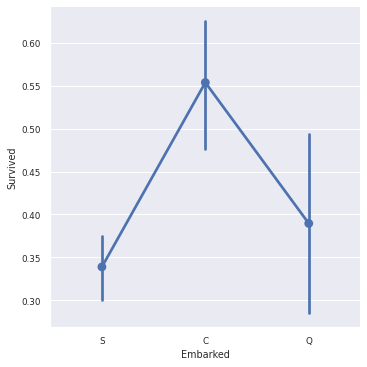

In [119]:
#탑승 항구별 생존율 비교
sns.catplot(x='Embarked', y='Survived', kind='point', data=data[data['TrainSplit']=='Train'])
plt.show()  #C항구 탑승자의 생존율이 높은 편임

In [120]:
#Cabin(객실 구역)
#고유 값 확인-알파벳과 숫자로 이루어져있음
data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [121]:
#첫번째 알파벳 이니셜 추출-str 속성으로 문자열을 추출하고, slice 함수로 문자열의 첫글자만을 선택함
data['Cabin'].str.slice(0,1).value_counts(dropna=False) #결측값(NaN)이 1014개임

NaN    1014
C        94
B        65
D        46
E        41
A        22
F        21
G         5
T         1
Name: Cabin, dtype: int64

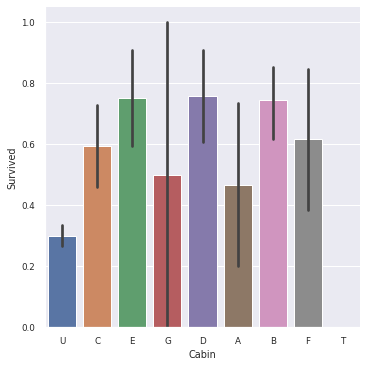

In [122]:
#알파벳 이니셜(U)로 결측값 대체
data['Cabin']=data['Cabin'].str.slice(0,1)
data['Cabin']=data['Cabin'].fillna('U')

#Cabin 구역별 생존율 비교
sns.catplot(x='Cabin', y='Survived', kind='bar', data=data[data['TrainSplit']=='Train'])
plt.show()  #결측값인 U의 생존률이 가장 낮음

In [123]:
#Ticket(탑승권)
#고유값 확인-알파벳과 숫자가 결합된 형태, 숫자로만 이루어진 데이터가 많음
data['Ticket'].value_counts(dropna=False)

CA. 2343       11
1601            8
CA 2144         8
PC 17608        7
347082          7
               ..
SCO/W 1585      1
348124          1
AQ/3. 30631     1
C 17369         1
240929          1
Name: Ticket, Length: 929, dtype: int64

In [124]:
#문자열 정리-알파벳 추출
data['Ticket']=data['Ticket'].str.replace(".","").str.replace("/","")
data['Ticket']=data['Ticket'].str.strip().str.split(' ').str[0]
data['Ticket'].value_counts(dropna=False)

PC         92
CA         68
A5         28
SOTONOQ    24
WC         15
           ..
345769      1
374910      1
334912      1
349234      1
17764       1
Name: Ticket, Length: 741, dtype: int64

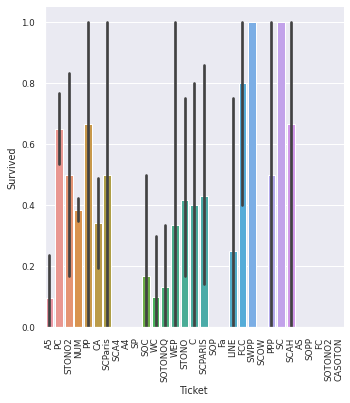

In [125]:
#문자열이 숫자로만 이루어졌을 경우 "NUM" 값으로 치환
data.loc[data['Ticket'].str.isdigit(), 'Ticket']='NUM'
data['Ticket'].value_counts(dropna=False)[:10]

#Ticket 번호별 생존율 비교
sns.catplot(x='Ticket', y='Survived', kind='bar', data=data[data['TrainSplit']=='Train'])
plt.xticks(rotation=90) #글자 방향 90도로 꺾기
plt.show()

In [126]:
#<데이터 전처리>
#Label Encoding-문자열인 'Title'열과 'AgeBin'열의 데이터를 숫자 레이블로 바꿈
from sklearn.preprocessing import LabelEncoder
for col in ['Title', 'AgeBin']:
  encoder=LabelEncoder()
  data[col]=encoder.fit_transform(data[col])

data.loc[:, ['Title', 'AgeBin']].head()

,Title,AgeBin
0,2,9
1,3,1
2,1,9
3,3,0
4,2,0


In [127]:
#변주형 변수로 변환 및 원핫 인코딩
onehot_prefix=[]
for col in ['Embarked', 'Cabin', 'Ticket']:
  data[col]=data[col].astype('category')
  data=pd.get_dummies(data, columns=[col], prefix=col[:3], drop_first=True)
  onehot_prefix.append(col[:3])

data.loc[:, [col for col in data.columns if col[:3] in onehot_prefix]].head()

,Emb_Q,Emb_S,Cab_B,Cab_C,Cab_D,Cab_E,Cab_F,Cab_G,Cab_T,Cab_U,Tic_A4,Tic_A5,Tic_AQ3,Tic_AQ4,Tic_AS,Tic_C,Tic_CA,Tic_CASOTON,Tic_FC,Tic_FCC,Tic_Fa,Tic_LINE,Tic_LP,Tic_NUM,Tic_PC,Tic_PP,Tic_PPP,Tic_SC,Tic_SCA3,Tic_SCA4,Tic_SCAH,Tic_SCOW,Tic_SCPARIS,Tic_SCParis,Tic_SOC,Tic_SOP,Tic_SOPP,Tic_SOTONO2,Tic_SOTONOQ,Tic_SP,Tic_STONO,Tic_STONO2,Tic_STONOQ,Tic_SWPP,Tic_WC,Tic_WEP
0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [134]:
#피처 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

#스케일링 처리할 피처 선택-TrainSplit 등 일부 열 제외
scaled_cols=[col for col in data.loc[:, 'Pclass':].columns if col!='TrainSplit']

data_scaled=data.loc[:, scaled_cols]
data_scaled=scaler.fit_transform(data_scaled)

#스케일링 변환된 값을 데이터 프레임에 반영
data.loc[:, scaled_cols]=data_scaled[:,:]
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,TrainSplit,Title,AgeBin,FamilySize,FareLog,Emb_Q,Emb_S,Cab_B,Cab_C,Cab_D,Cab_E,Cab_F,Cab_G,Cab_T,Cab_U,Tic_A4,Tic_A5,Tic_AQ3,Tic_AQ4,Tic_AS,Tic_C,Tic_CA,Tic_CASOTON,Tic_FC,Tic_FCC,Tic_Fa,Tic_LINE,Tic_LP,Tic_NUM,Tic_PC,Tic_PP,Tic_PPP,Tic_SC,Tic_SCA3,Tic_SCA4,Tic_SCAH,Tic_SCOW,Tic_SCPARIS,Tic_SCParis,Tic_SOC,Tic_SOP,Tic_SOPP,Tic_SOTONO2,Tic_SOTONOQ,Tic_SP,Tic_STONO,Tic_STONO2,Tic_STONOQ,Tic_SWPP,Tic_WC,Tic_WEP
0,1,0.0,1.0,1.0,0.273456,0.125,0.0,0.014151,Train,0.285714,1.000000,0.1,0.338125,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,0.0,0.0,0.473882,0.125,0.0,0.139136,Train,0.428571,0.111111,0.1,0.685892,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,1.0,0.0,0.323563,0.000,0.0,0.015469,Train,0.142857,1.000000,0.0,0.350727,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,1.0,0.0,0.0,0.436302,0.125,0.0,0.103644,Train,0.428571,0.000000,0.1,0.639463,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,1.0,1.0,0.436302,0.000,0.0,0.015713,Train,0.285714,0.000000,0.0,0.352955,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
#피처 선택
selected_features = ['Pclass','Sex','SibSp','Parch','Title','AgeBin','FamilySize','FareLog','Emb_Q','Emb_S','Cab_B','Cab_C',
                     'Cab_D','Cab_E','Cab_F','Cab_G','Cab_T','Cab_U','Tic_A4','Tic_A5','Tic_AQ3','Tic_AQ4','Tic_AS','Tic_C',
                     'Tic_CA','Tic_CASOTON','Tic_FC','Tic_FCC','Tic_Fa','Tic_LINE','Tic_LP','Tic_NUM','Tic_PC','Tic_PP','Tic_PPP',
                     'Tic_SC','Tic_SCA3','TicSCA4','Tic_SCAH','Tic_SCOW','Tic_SCPARIS','Tic_SCParis','Tic_SOC','Tic_SOP','Tic_SOPP',
                     'Tic_SOTONO2','Tic_SOTONOQ','Tic_SP','Tic_STONO','Tic_STONO2','Tic_STONOQ','Tic_SWPP','Tic_WC','Tic_WEP']
len(selected_features)

54

In [154]:
#학습용 데이터와 예측대상인 테스트 데이터 구분
y_train=data.loc[data['TrainSplit']=='Train', 'Survived']
x_train=data.loc[data['TrainSplit']=='Train' ] #select_features는 더이상 지원하지 않는 기능이므로 뺐음
x_test=data.loc[data['TrainSplit']=='Test']
print("Train 데이터셋 크기:", x_train.shape, y_train.shape)
print("Test 데이터셋 크기:", x_test.shape)

Train 데이터셋 크기: (891, 59) (891,)
Test 데이터셋 크기: (418, 59)


In [152]:
#훈련 - 검증 데이터 분할
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=20)

print("훈련 데이터셋 크기:", x_tr.shape, y_tr.shape)
print("검증 데이터셋 크기:", x_val.shape, y_val.shape)

훈련 데이터셋 크기: (712, 59) (712,)
검증 데이터셋 크기: (179, 59) (179,)


In [157]:
#로지스틱 회귀 모델
lr_model=LogisticRegression()
lr_model.fit(x_tr, y_tr)

y_tr_pred=lr_model.predict(x_tr)
print("훈련 Accuracy: %.4f" %accuracy_score(y_tr, y_tr_pred))
print("훈련 AUC: %.4f" %roc_auc_score(y_re, y_tr_pred))

y_val_pred=lr_model.predict(x_val)
print("검증 Accuracy: %.4f" %accuracy_score(y_val, y_val_pred))
print("검증 AUC: %.4f" %roc_auc_score(y_val, y_val_pred))

ValueError: ignored